In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [5]:
!ls {NSYNTH_AUDIO}

models				train_guitar_clean_40_88.csv
test				train_keyboard_clean_21_108.csv
test_guitar_clean_40_88.csv	valid
test_keyboard_clean_21_108.csv	valid_guitar_clean_40_88.csv
train				valid_keyboard_clean_21_108.csv


In [6]:
!ls tmp_labels

test_guitar_clean_40_88.csv	train_keyboard_clean_21_108.csv
test_keyboard_clean_21_108.csv	valid_guitar_clean_40_88.csv
train_guitar_clean_40_88.csv	valid_keyboard_clean_21_108.csv


In [7]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [8]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [9]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [10]:
trn_list, val_list, tst_list = [AudioItemList.from_df(df, path=NSYNTH_AUDIO, 
                                                      folder=folder, suffix='.wav')
                                for df, folder in zip([trn_df, val_df, tst_df], 
                                                      ['train', 'valid', 'test'])]
len(trn_list), len(val_list), len(tst_list)

(16915, 1112, 347)

In [11]:
def get_frame(x):
    start = 1024
    frame_len = 1024
    return x[start:start+frame_len]

In [12]:
tfm_list = [get_frame]
tfms = (tfm_list, tfm_list) # train, valid tfms 

n_fft = 512 
n_hop = 256
n_mels = 64
sample_rate = 16000
ref = 'max'
top_db = 50.0
bs = 32

data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .add_test(tst_list)
            .transform(tfms)
            .databunch(bs=bs))
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([32, 1024]), torch.Size([32]), tensor(-0.8722), tensor(0.9465))

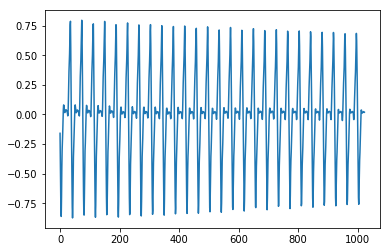

In [13]:
plt.plot(xs[0])

In [16]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(1024, 1024, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(1024, 512, actn=nn.ReLU(inplace=True)),
            *bn_drop_lin(512, n_classes, actn=None),
        )
    def forward(self, x):
        return self.layers(x)

In [17]:
model = SimpleModel(data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________________
Linear               [32, 1024]           1049600    True      
______________________________________________________________________
ReLU                 [32, 1024]           0          False     
______________________________________________________________________
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________________
Linear               [32, 512]            524800     True      
______________________________________________________________________
ReLU                 [32, 512]            0          False     
______________________________________________________________________
BatchNorm1d          [32, 512]            1024       True      
______________________________________________________________

In [18]:
model_name = 'pitch_frame_v1'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,1.201909,0.702092,0.779676
2,0.840669,0.417505,0.880396
3,0.525824,0.193923,0.958633
4,0.344534,0.142648,0.963130


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


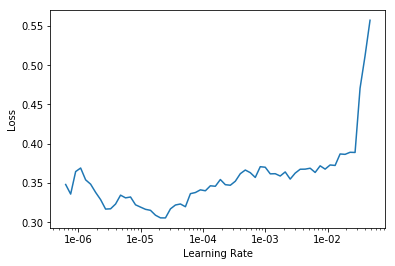

In [19]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.342822,0.135537,0.967626
2,0.350471,0.131906,0.970324
3,0.385283,0.170174,0.942446
4,0.332641,0.152978,0.959532
5,0.278188,0.113127,0.967626
6,0.244537,0.119419,0.959532
7,0.261006,0.108091,0.964928
8,0.239937,0.110310,0.967626


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


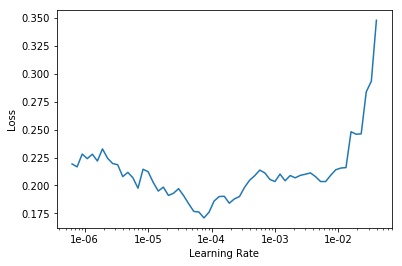

In [21]:
learn.load(model_name + '-stage-2')
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=1e-3)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,accuracy
1,0.251444,0.104230,0.967626
2,0.288094,0.114215,0.960432
3,0.322787,0.162742,0.949640
4,0.328071,0.145071,0.952338
5,0.275119,0.108753,0.970324
6,0.237573,0.120393,0.963130
7,0.206974,0.105555,0.967626
8,0.196873,0.100890,0.973022


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


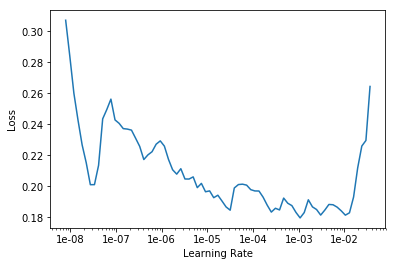

In [23]:
learn.load(model_name + '-stage-3')
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [24]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=1e-4)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy
1,0.208807,0.108358,0.969424
2,0.230615,0.094122,0.975719
3,0.198218,0.096930,0.974820
4,0.203226,0.102230,0.971223
5,0.200530,0.100784,0.972122
6,0.191049,0.102604,0.971223
7,0.203926,0.095916,0.973921
8,0.190772,0.096210,0.976619


In [25]:
learn.load(model_name + '-stage-3')
learn.fit_one_cycle(8, max_lr=1e-5)
learn.save(model_name + '-stage-4')

epoch,train_loss,valid_loss,accuracy
1,0.195276,0.106581,0.969424
2,0.208572,0.102337,0.974820
3,0.218549,0.094202,0.974820
4,0.203664,0.098852,0.967626
5,0.223389,0.105279,0.970324
6,0.216043,0.103227,0.969424
7,0.185437,0.105510,0.968525
8,0.205683,0.098810,0.974820


In [26]:
accuracy(*learn.get_preds())

tensor(0.9748)

In [27]:
n_errors = round(float(1 - accuracy(*learn.get_preds(DatasetType.Train))) * len(trn_list))
print(n_errors, 'errors')

713 errors
